#  XPCS   SAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
#hdr = db[{{ uid }}]

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [4]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages
#register the fancy lazy chx eiger handler
from chxtools import handlers

### Lazy Eiger Handler (later will goto databroker)

In [5]:
#%matplotlib notebook
%matplotlib inline

### Get the events from the uid

In [6]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [7]:
uid = 'c423e856'
hdr = db[uid]

In [10]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'], fill = True)

hdf5 path = /XF11ID/data/2015/10/30/915b6fb3-aaf6-44f0-a999_9092_master.h5


In [11]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/10/30/'

In [12]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 2500 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [13]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 336.0,
 'count_time': 0.0049999999,
 'detector_distance': 4.8400002,
 'frame_time': 0.00501,
 'incident_wavelength': 1.3794414,
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [14]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(0.00501, 0.0049999999)

## load a mask if exist 
### otherwise create a mask using Mask pipeline

In [15]:
mask = np.load(uid+"_mask.npy")
#mask = np.load( path +  str(uid)+"_mask.npy"))

## Plot the mask

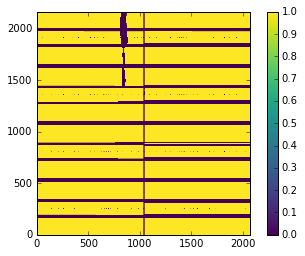

In [16]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

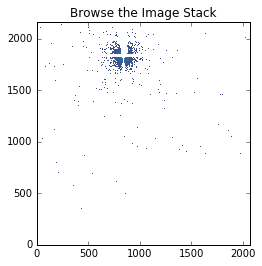

<function __main__.view_image>

In [17]:
from ipywidgets import interact

def view_image(i):
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e10 ) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, Nimg-1))

### hey, let's see if any images are bad!

In [18]:
bin_img = 25
imgsum = [np.sum(img *mask) for img in imgs[::bin_img]]

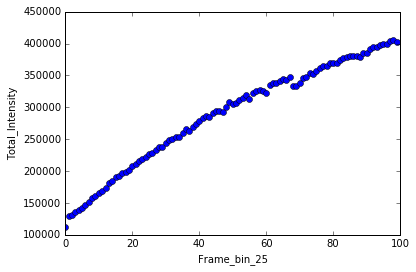

In [19]:
fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

### Get the Averaged Image Data

In [20]:
avg_img = np.average(imgs[::50], axis=0)*mask

## Plot the averged image with the mask

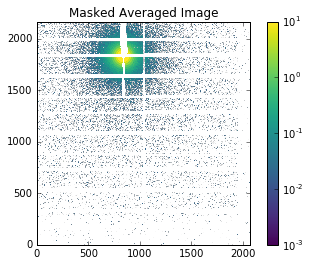

In [21]:
img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Import all the required packages for  Data Analysis

* scikit-beam - data analysis tools for X-ray science 
    - https://github.com/scikit-beam/scikit-beam
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [22]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skbeam.core.roi as roi

import skbeam.core.correlation as corr
import skbeam.core.utils as utils

## Get the approximate center and see the statistic to make sure 

In [23]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(840.0, 336.0)

In [24]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]  # center of the speckle pattern
center=[center[1], center[0]]

center

[1830, 840]

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [25]:
bin_centers, ring_averages= roi.circular_average(img_mask, 
        center, threshold=0, nx=2000, pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

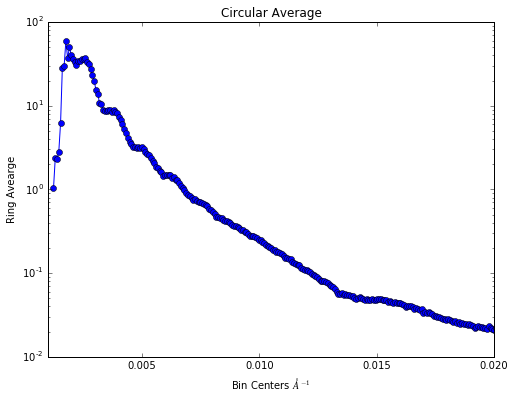

In [26]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0.001, 0.02)
axes.set_ylim(0.01, 100)
plt.show()

## Create label array (Q rings)

In [27]:
inner_radius = 44  # radius of the first ring
width = 2       # width of each ring
spacing =  (119 - 44)/9 - 2    # spacing between rings
num_rings = 10   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  44.        ,   46.        ],
       [  52.33333333,   54.33333333],
       [  60.66666667,   62.66666667],
       [  69.        ,   71.        ],
       [  77.33333333,   79.33333333],
       [  85.66666667,   87.66666667],
       [  94.        ,   96.        ],
       [ 102.33333333,  104.33333333],
       [ 110.66666667,  112.66666667],
       [ 119.        ,  121.        ]])

In [28]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00307454,  0.0036439 ,  0.00421326,  0.00478262,  0.00535198,
        0.00592134,  0.00649069,  0.00706005,  0.00762941,  0.00819877])

In [29]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

## Extract the labeled array

In [30]:
ring_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
labels, indices = roi.extract_label_indices(ring_mask)

In [32]:
labels

array([10, 10, 10, ..., 10, 10, 10])

In [33]:
indices

array([3540525, 3540526, 3540527, ..., 4029094, 4031159, 4031160])

## Number of pixels in each q ring

In [34]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([ 222,  337,  458,  536,  661,  769,  879,  986, 1090, 1194])

# check center

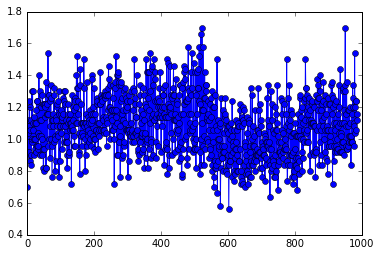

In [35]:
pixel = roi.roi_pixel_values(avg_img*mask, ring_mask, [8] )
fig, ax = plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )
plt.show()

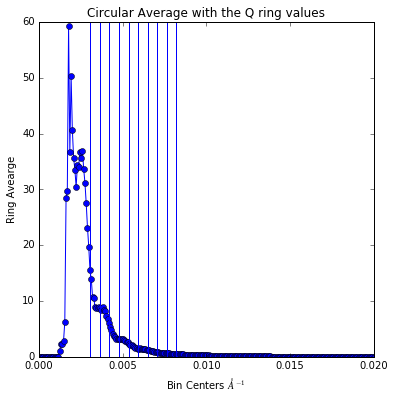

In [36]:
fig, axes = plt.subplots( figsize=(6, 6))
#axes.semilogy(q_val, ring_averages, '-o')
axes.plot(q_val, ring_averages, '-o')
axes.set_title('Circular Average with the Q ring values')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0, 0.02)
#axes.set_ylim(0, 100)
for i in range(num_rings):
    axes.axvline(q_ring_center[i])
plt.show()

## To mask the each image

In [37]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [38]:
masker = Masker(imgs, mask)

(1630, 2030)

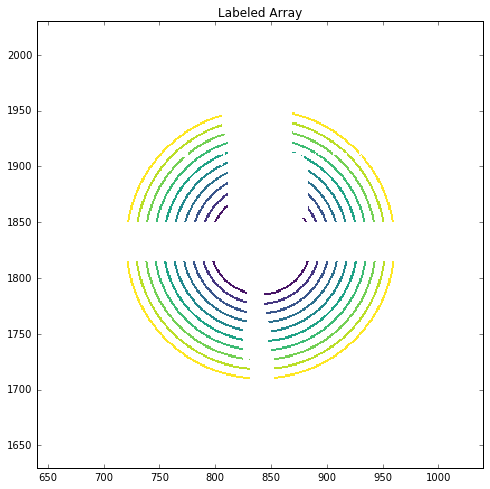

In [39]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 200 

x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])


##  Kymograph(waterfall plot) of a ring

In [40]:
kymo = roi.kymograph(masker[::50], ring_mask, num = 4)  # eg: num=4 , 4th ring

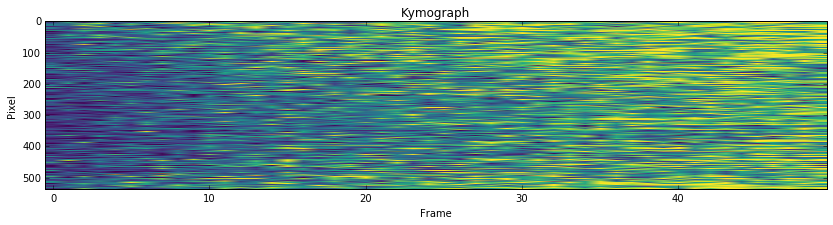

In [41]:
fig, ax = plt.subplots(figsize=(14,10))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(kymo.T, cmap='viridis', vmax=10)
#fig.colorbar( im   )
ax.set_aspect(0.02)
plt.show()

##  Mean intensities for each ring

In [42]:
mask_data = masker[::50]  #this one is too slow if make  masker[::1]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [43]:
mean_int_sets.shape

(50, 10)

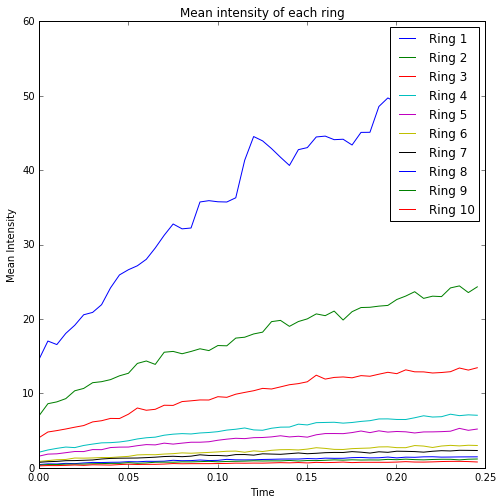

In [44]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [45]:
ring_mask = np.array(ring_mask, dtype=int)

In [74]:
num_lev = 4  # number of levels
num_buf = 8  # number of buffers

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         ring_mask, imgs)

### Plot the one time correlation functions

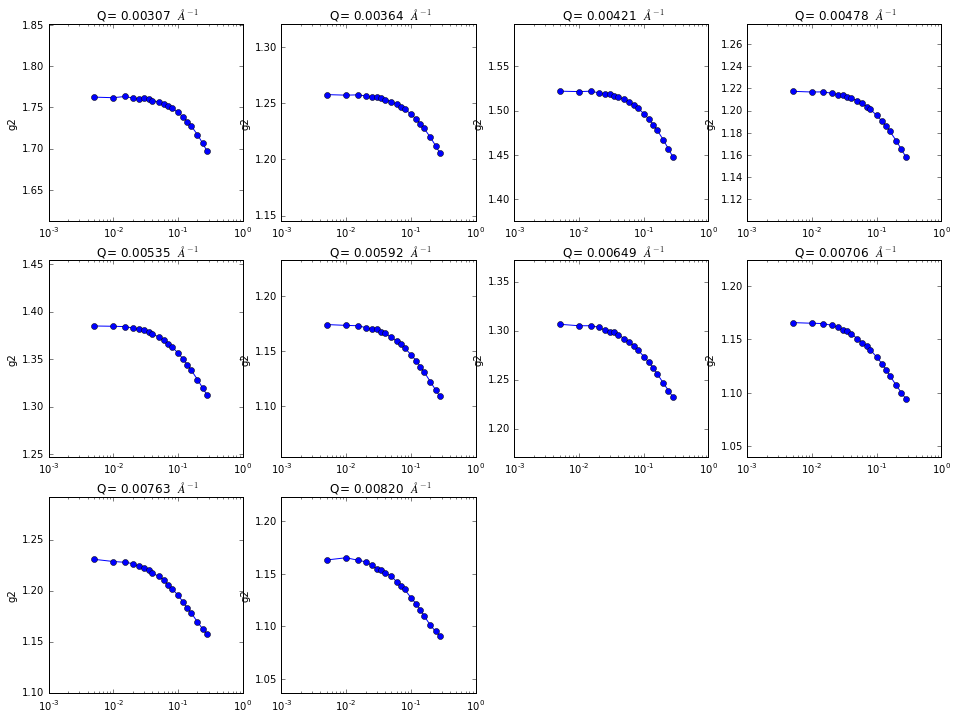

In [75]:
lags = lag_steps*timeperframe

sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y=g2[:, i]
    ax.semilogx(lags, y, '-o', markersize=6) 
    ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
plt.show()
fig.tight_layout()  

# Fit g2

In [76]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


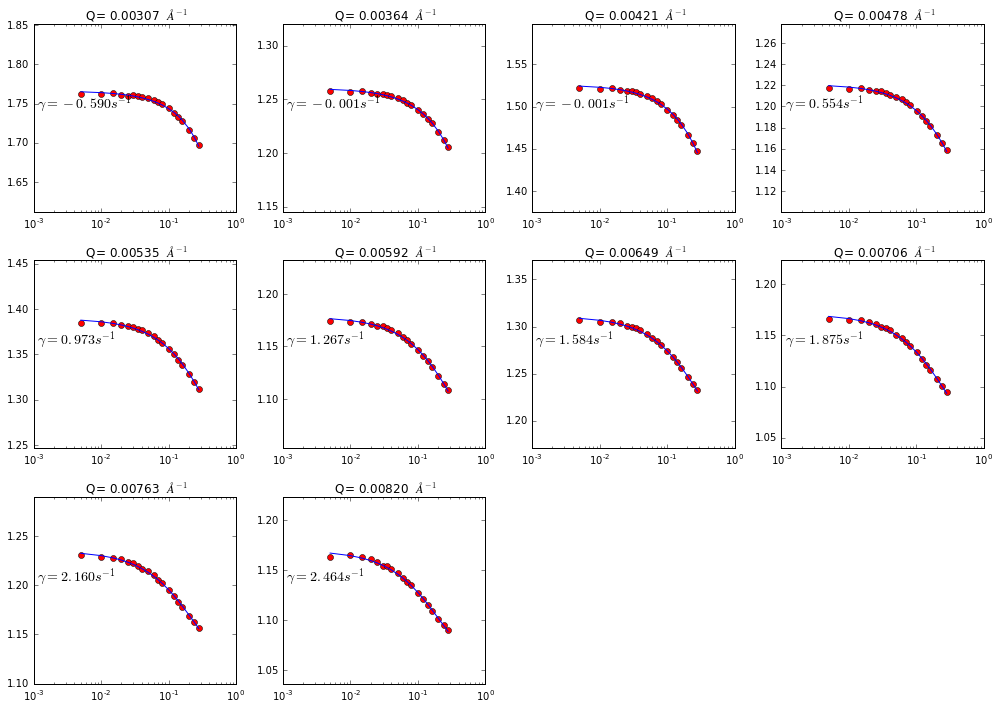

In [77]:
rate = []  #  relaxation rate

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid, fontsize=20, y =1.02) 
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    y=g2[1:, i]
    result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
    rate.append(result1.best_values['relaxation_rate'])
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rate[i]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
fig.tight_layout()  
plt.show()

In [78]:
rate

[-0.59037400748109392,
 -0.0012945828192495398,
 -0.00074691042486134309,
 0.55361276238287738,
 0.97323055947118831,
 1.2668460913604209,
 1.5844783054118228,
 1.8745247470716864,
 2.1597059987013583,
 2.463890795932334]

In [79]:
result1.best_values

{'baseline': 1.0620401177571537,
 'beta': 0.10784372128507919,
 'relaxation_rate': 2.463890795932334}

## Plot the relaxation rates vs (q_ring_center)**2

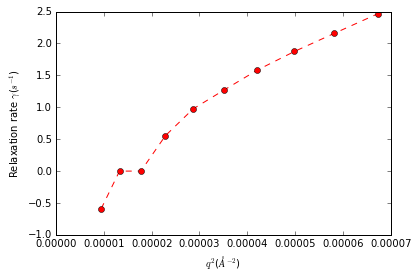

In [80]:
fig, ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Fitted the Diffusion Coefficinet D0

In [81]:
r'($\AA^{-2}$)'

'($\\AA^{-2}$)'

In [82]:
D0 = np.polyfit(q_ring_center**2, rate, 1)
gmfit = np.poly1d(D0)
'The fitted diffusion coefficient D0 is:  %.2E'r'($\AA^{-2}$)'%D0[0]

'The fitted diffusion coefficient D0 is:  5.11E+04($\\AA^{-2}$)'

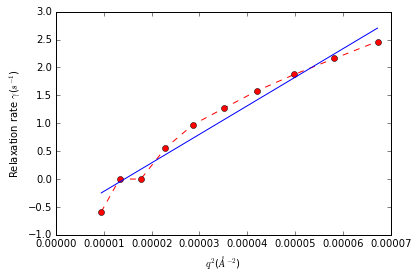

In [83]:
fig, ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## Removing bad images 

In [85]:
import skbeam.core.mask as mask

bad_img_list = [2, 30, 206, 300, 405]

new_imgs = mask.bad_to_nan_gen(imgs, bad_img_list)

In [86]:
g2_n, lag_steps_n = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         ring_mask, new_imgs)

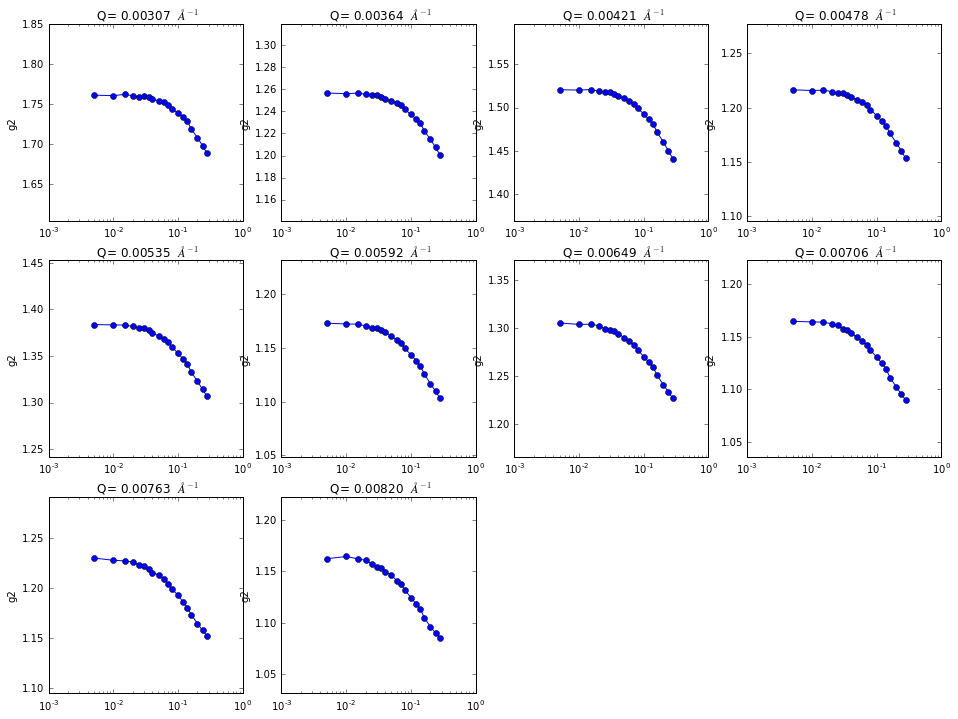

In [89]:
lags_n = lag_steps_n*timeperframe

sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y_n = g2_n[:, i]
    ax.semilogx(lags_n, y_n, '-o', markersize=6) 
    ax.set_ylim([min(y_n)*.95, max(y_n[1:])*1.05 ])
plt.show()
fig.tight_layout()  